Following: https://github.com/strongio/keras-bert/blob/master/keras-bert.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

In [3]:
import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Lambda, Activation, Conv1D, \
                                    MaxPooling1D, Flatten, Reshape, add

from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, SGD

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.regularizers import l2

from keras.utils import to_categorical

Using TensorFlow backend.


In [4]:
from src.keras_bert import convert_text_to_examples, \
                           create_tokenizer_from_hub_module, \
                           convert_examples_to_features, \
                           initialize_vars, \
                           BertLayer

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score as scikit_f1_score

In [6]:
# Initialize session
sess = tf.Session()

#### Custom Functions

In [7]:
from src.callbacks import PlotCurvesTF as PlotCurves
from src.eval_metrics import f1_micro, f1_macro
from src.load_data import load_data

### Load Data

In [8]:
train_data, valid_data, test_data, metadata = load_data()

### Prepare data

In [17]:
n_tags = 2
batch_size = 32
max_seq_length = 256
if max_seq_length > 512:
    print('!!!!!!! WARNING: BERT does not accept lenght > 512. It is set to 512.')
    max_seq_length = 512

In [18]:
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

In [19]:
def get_input(data_, max_seq_length, n_tags, bert_path, is_test):
    
    tokenizer = create_tokenizer_from_hub_module(bert_path)
    
    # !!! For BERT input, each sentence should be in an array
    X = np.array([[" ".join(sentence['sentence'].replace('\n', '').strip().lower().split()[0:max_seq_length])]
                  for article in data_ 
                  for sentence in article['sentences']], dtype=object)

    y = [sentence['label'] 
         for article in data_
         for sentence in article['sentences']]
    
    examples_ = convert_text_to_examples(X, y)
    
    (input_ids, input_masks, segment_ids, labels_) = \
            convert_examples_to_features(tokenizer, examples_, max_seq_length=max_seq_length)
    
    if not is_test:
        labels_ = to_categorical(labels_, num_classes=n_tags)
    
    return [input_ids, input_masks, segment_ids], labels_

In [20]:
X_tra, y_tra = get_input(train_data, max_seq_length, n_tags, bert_path, False)
X_val, y_val = get_input(valid_data, max_seq_length, n_tags, bert_path, False)
X_test, y_test = get_input(test_data, max_seq_length, n_tags, bert_path, True)

Converting examples to features: 100%|██████████| 441/441 [00:00<00:00, 2523.90it/s]


## Build Model

In [21]:
def build_model_0(max_seq_length):
    in_id = Input(shape=(max_seq_length,), name="input_ids")
    in_mask = Input(shape=(max_seq_length,), name="input_masks")
    in_segment = Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]

    bert_output = BertLayer(n_fine_tune_layers=3, bert_path=bert_path)(bert_inputs)
    
    dense = Dense(256, activation="relu")(bert_output)
#     dense = Dense(256, activation="relu")(dense)
    
    pred = Dense(2, activation="sigmoid")(dense)

    return Model(inputs=bert_inputs, outputs=pred)

In [22]:
learningrate=0.001 # 0.01
optimizer = Adam(lr=learningrate)
optimizer_str = 'Adam'
loss = 'binary_crossentropy'
metrics = ['acc', f1_macro, f1_micro]

In [23]:
model = build_model_0(max_seq_length)#, n_tags)
model.summary()

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert_layer_1 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [24]:
model_name = 'RQ1_test_bert_model_0' + \
             '_' + optimizer_str +  \
             '_lr_' + str(learningrate) +  \
             '_lrreduction' + \
             '_loss_' + loss

model_dir = './Model/' + model_name.split('model')[0] + 'model/' + model_name
results_file = os.path.join(model_dir, 'model_results_file.txt')

### Train

In [25]:
# Instantiate variables
initialize_vars(sess)

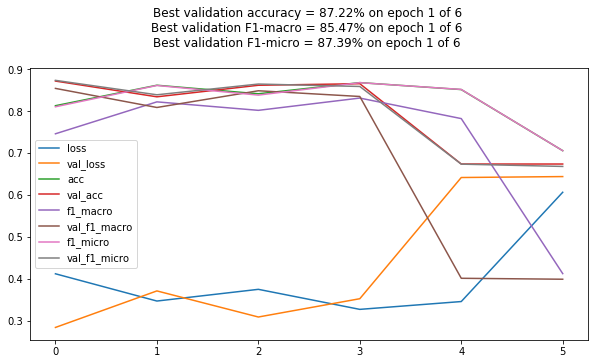

3582/3582 [==============================] - 123s 34ms/sample - loss: 0.6068 - acc: 0.7060 - f1_macro: 0.4126 - f1_micro: 0.7060 - val_loss: 0.6442 - val_acc: 0.6742 - val_f1_macro: 0.3992 - val_f1_micro: 0.6684
Epoch 7/20
 320/3582 [=>............................] - ETA: 1:42 - loss: 0.5952 - acc: 0.7188 - f1_macro: 0.4174 - f1_micro: 0.7188

KeyboardInterrupt: 

In [26]:
model.fit(X_tra, y_tra, 
          epochs=20, 
          batch_size=batch_size, 
          validation_data=(X_val, y_val),
          callbacks=[
              PlotCurves(model_name=model_name, model_dir=model_dir, jnote=True),
#               ReduceLROnPlateau(monitor='val_f1_macro', patience=5, 
#                                 factor=0.1, min_lr=0.00001),
#               EarlyStopping(monitor='val_f1_macro', min_delta=0, patience=10, mode='max')
          ])

### Load the best Model

In [20]:
model_name

'RQ1_test_bert_model_0_Adam_lr_0.001_lrreduction_loss_binary_crossentropy'

In [21]:
best_model = load_model(os.path.join(model_dir, model_name + '_best_f1_macro_model.h5'), 
                        custom_objects={'BertLayer':BertLayer, 'tf':tf, 
                                        'f1_macro':f1_macro, 'f1_micro':f1_micro})

W0907 23:12:26.461947 139851956260992 deprecation.py:506] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0907 23:12:26.462655 139851956260992 deprecation.py:506] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


ValueError: Shapes (768,) and (512, 768) are incompatible

In [29]:
best_model = model

### Evaluation

In [30]:
def get_scores(model, data_, batch_size, max_seq_length, n_tags, 
               bert_path, results_file, print_out=False):
    
    X, y = get_input(data_, max_seq_length, n_tags, bert_path, True)
    
    y_preds = model.predict(X, batch_size=batch_size)
    y_preds = np.argmax(y_preds, axis=1)
    
    clsrpt = classification_report(y, y_preds)
    sfm = scikit_f1_score(y, y_preds, average='macro')
    
    if print_out:
        print(clsrpt)
        print('\nScikit_F1_Macro:', sfm)

    if results_file:
        with open(results_file, 'a') as f:
            f.write('\n' + clsrpt + '\n' + str(sfm) + '\n\n')
            
    return sfm

#### Validation Set

In [31]:
with open(results_file, 'w') as f:
    f.write('\n---------------- Validation ----------------\n')
val_f1 = get_scores(best_model, valid_data, batch_size, max_seq_length, 
                    n_tags, bert_path, results_file, print_out=True)

Converting examples to features: 100%|██████████| 399/399 [00:00<00:00, 2611.52it/s]


              precision    recall  f1-score   support

           0       0.67      1.00      0.81       269
           1       0.00      0.00      0.00       130

   micro avg       0.67      0.67      0.67       399
   macro avg       0.34      0.50      0.40       399
weighted avg       0.45      0.67      0.54       399


Scikit_F1_Macro: 0.4026946107784431


/home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Test Set

In [32]:
with open(results_file, 'a') as f:
    f.write('\n---------------- Test ----------------\n')
test_f1 = get_scores(best_model, test_data, batch_size, max_seq_length, 
                     n_tags, bert_path, results_file, print_out=True)

Converting examples to features: 100%|██████████| 441/441 [00:00<00:00, 2597.09it/s]


              precision    recall  f1-score   support

           0       0.74      1.00      0.85       325
           1       0.00      0.00      0.00       116

   micro avg       0.74      0.74      0.74       441
   macro avg       0.37      0.50      0.42       441
weighted avg       0.54      0.74      0.63       441


Scikit_F1_Macro: 0.42428198433420367


# Oylesine birden alinan sonuclar

##### Validation

In [41]:
y_val_true = np.array([sentence['label'] for article in valid_data 
                                 for sentence in article['sentences']])

y_val_preds = model.predict(X_val, batch_size=32)
y_val_preds = np.argmax(y_val_preds, axis=1)

print(classification_report(y_val_true, y_val_preds))
with open(results_file, 'a') as f:
    f.write(classification_report(y_val_true, y_val_preds))
    f.write('\n')

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       269
           1       0.73      0.87      0.80       130

   micro avg       0.85      0.85      0.85       399
   macro avg       0.83      0.86      0.84       399
weighted avg       0.87      0.85      0.86       399



In [44]:
scikit_f1_score(y_val_true, y_val_preds,average='macro')

0.841467090480627

##### Test

In [48]:
y_preds = model.predict(X_test, batch_size=32)
y_preds = np.argmax(y_preds, axis=1)

In [49]:
### build_flat_model_1 results
print(classification_report(y_test, y_preds))
with open(results_file, 'a') as f:
    f.write(classification_report(y_test, y_preds))
    f.write('\n')

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       325
           1       0.75      0.78      0.76       116

   micro avg       0.87      0.87      0.87       441
   macro avg       0.83      0.84      0.84       441
weighted avg       0.88      0.87      0.87       441



In [50]:
scikit_f1_score(y_test, y_preds, average='macro')

0.8388746803069054